# Shrub detection - training data

We've got a collection of polygons in a shapefile, and some aerial imagery captured by a drone covering the same region.

In this notebook we'll take those datasets and turn them into _training data_ that a deep learning model can use to identify shrubs from aerial imagery.

## Setting up

Install the software packages we need to work with geospatial data, some functions to make it easier, via the [shrub-prepro](https://github.com/MAMBO-Horizon-WP4/shrub-prepro) repository.

Next `import` the packages we'll use directly, and set the connection details to our data store.

In [ ]:
%pip install git+https://github.com/MAMBO-Horizon-WP4/shrub-prepro

In [2]:
import os
import s3fs
import rasterio
import geopandas as gpd
from rasterio.windows import Window
from shapely.geometry import shape, box
from pathlib import Path
from rasterio.plot import show
from rasterio.features import rasterize
import numpy as np
from tqdm import tqdm

Set our connnection details for reading the data from JASMIN storage.

In [95]:
import os
os.environ['AWS_S3_ENDPOINT'] = 'address_without_https_prefix'
os.environ['AWS_ENDPOINT_URL'] = 'address_with_https_prefix'
os.environ['AWS_VIRTUAL_HOSTING']="False"
os.environ['AWS_HTTPS']="True"
os.environ['AWS_NO_SIGN_REQUEST'] = "True"
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

s3 = s3fs.S3FileSystem(anon=True)

These are the files we'll be working with - a shapefile of polygons, and the RGB Structure from Motion image

In [96]:
s3.ls('s3://shrub-prepro/input/')

['shrub-prepro/input/reprojected_yellow_low_shrub.cpg',
 'shrub-prepro/input/reprojected_yellow_low_shrub.dbf',
 'shrub-prepro/input/reprojected_yellow_low_shrub.prj',
 'shrub-prepro/input/reprojected_yellow_low_shrub.qix',
 'shrub-prepro/input/reprojected_yellow_low_shrub.shp',
 'shrub-prepro/input/reprojected_yellow_low_shrub.shx',
 'shrub-prepro/input/reprojected_yellow_low_shrub.zip',
 'shrub-prepro/input/rgb_sfm.tif',
 'shrub-prepro/input/slp_sfm.tif']

Our shrub polygons are held in a shapefile; let's open it up and have a look at the plot

<Axes: >

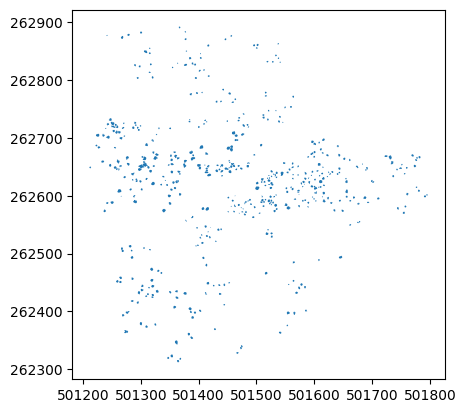

In [5]:
shrubs = gpd.read_file("s3://shrub-prepro/input/reprojected_yellow_low_shrub.zip")
shrubs.plot()

In [6]:
five_rows = shrubs.head()
five_rows

,id,area,geometry
0,1.0,1,"POLYGON ((501491.028 262586.114, 501491.302 26..."
1,1.0,1,"POLYGON ((501485.916 262592.442, 501486.586 26..."
2,1.0,1,"POLYGON ((501487.955 262594.572, 501488.685 26..."
3,NaN,1,"POLYGON ((501481.139 262591.256, 501481.778 26..."
4,NaN,1,"POLYGON ((501469.882 262586.022, 501471.403 26..."


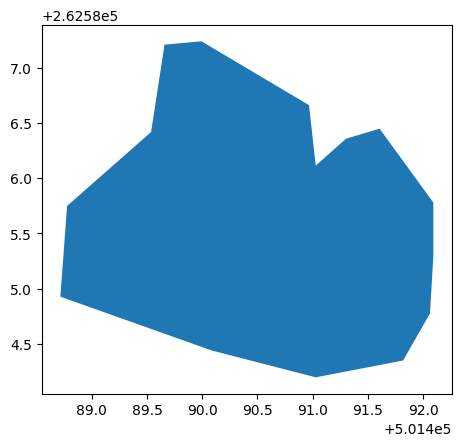

In [98]:
first_row = shrubs.head(1)
first_row.plot();

Now we can open our very large raster image.

Rather than reading the whole thing at once, we'll build up our training data by reading small windows from it, framed by the shrub polygones.

In [10]:
image = rasterio.open('s3://shrub-prepro/input/rgb_sfm.tif')

In [ ]:
print(image.bounds)
print(f"Image width: {image.width} pixels")
print(f"Image height: {image.height} pixels")

BoundingBox(left=500465.6386877574, bottom=261601.73161492136, right=502200.4930388408, top=263510.4931308167)
Image width: 107778 pixels
Image height: 118582 pixels


## Read a window

We can use a Window to read a small area from the much larger image in a quicker way.

This function will create a window of a given size around a polygon.

* Find the centre of the polygon, in coordinates
* Use `image.index` to convert the coordinates to a pixel location in the image
* Use that pixel location as the centre of a window, in this case 512 x 512 pixels in size

Assumes that the image and the shapefile use the same projection!

In [8]:
def patch_window(geom: gpd.geoseries.GeoSeries, image: rasterio.DatasetReader, patch_size: int = 512) -> rasterio.windows.Window:
    """
    """
    patch_size = 512
    half_patch = patch_size // 2


    center_x, center_y = geom.centroid.x, geom.centroid.y
    row_col = image.index(center_x, center_y)

    window = Window(
          row_col[1] - half_patch, row_col[0] - half_patch, patch_size, patch_size
    )
    return window

Now we use that function to find that window within the image, and read from it

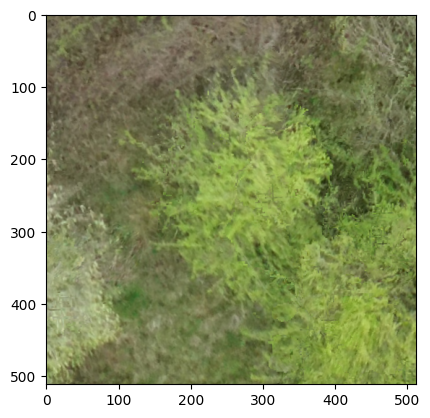

<Axes: >

In [12]:
window = patch_window(first_row, image)
image_patch = image.read(window=window)

show(image_patch)


We want to make sure that each of our label patches includes information about all the shrubs contained in it, not just the central one.

In [78]:
def shrub_labels_in_window(geometries: gpd.GeoSeries, window: rasterio.windows.Window, image: rasterio.DatasetReader) -> gpd.GeoSeries:
    """
    Works out the intersection between all the shrubs and a window within the image.
    """
    transform = rasterio.windows.transform(window, image.transform)
    bounds = rasterio.windows.bounds(window, image.transform)
    bbox = box(*bounds)
    s = geometries.intersection(bbox)
    out_series = s[~(s.is_empty)]
    return out_series


<Axes: >

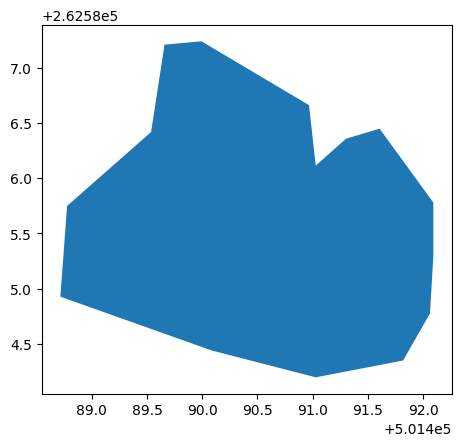

In [81]:
shrub_labels_in_window(shrubs, window, image).plot()

For our training data, we want to show the model two sets of inputs.

* An example image
* A label for each pixel in the image, showing where our objects of interest are and where they aren't.

In this case our labels are _binary_, e.g. areas of the image are either shrubs, or they're not.

This function uses our image and window to create a matching label for our image patch.

* First `transform` our pixel coordinates back into geographic coordinates
* Then `rasterize` the polygons that outline our shrub

In [72]:
def label_patch_with_window(geoms: gpd.GeoSeries, window: rasterio.windows.Window, image: rasterio.DatasetReader) -> None:
    transform = rasterio.windows.transform(window, image.transform)
    arr = rasterize(geoms.geometry,
                    out_shape=(int(window.height), int(window.width)),
                    transform=transform,
                    default_value=255)
    return arr

Let's call the function with the first row in our shapefile, and have a look at it:

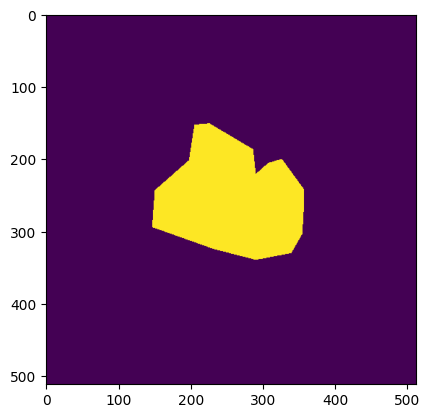

<Axes: >

In [83]:
labels = shrub_labels_in_window(shrubs, window, image)
arr = label_patch_with_window(labels, window, image)
show(arr)

This is a _single band_ image in which each pixel has one of two values.

By default, `rasterize` would make that 0 and 1, but if we save that as a greyscale image then the colours are impossible for the human eye to distinguish.

So we use the value 255 for our shrub pixels, which makes them appear white in the saved image.

In [84]:
np.unique(arr)



array([  0, 255])

We'll define a couple of very similar functions that save our images to individual files, in separate directories named `images` and `labels`

Notice that both these functions accept a numeric `index` - so we can later use them to process a list of images and name them in a sequence.

In [86]:
def save_label_patch(data: np.ndarray, window: rasterio.windows.Window, image: rasterio.DatasetReader, index: int, label: str = 'shrubs', dir: str='labels') -> None:
    transform = rasterio.windows.transform(window, image.transform)
    meta = image.meta.copy()
    meta.update(
         {
              "height": window.height,
              "width": window.width,
              "transform": transform,
              "count": 1,
          }
    )

    original_path = os.path.join(output_dir, dir, f"{label}_{index}.tif")
    with rasterio.open(original_path, "w", **meta) as dst:
        dst.write(data, 1)

def save_image_patch(window: rasterio.windows.Window, image: rasterio.DatasetReader, index: int, label: str="shrubs", dir: str='images') -> rasterio.DatasetReader:
    # Extract the image data for the current patch
    image_patch = image.read(window=window)
     # Save the original window
    transform = rasterio.windows.transform(window, image.transform)
    meta = image.meta.copy()
    meta.update(
         {
              "height": window.height,
              "width": window.width,
              "transform": transform,
          }
    )

    original_path = os.path.join(output_dir,dir, f"{label}_{index}.tif")
    with rasterio.open(original_path, "w", **meta) as dst:
        dst.write(image_patch)

Create a new directory to save our data into, in "labels" and "images" directories.

In [88]:
output_dir = 'shrub_training_data'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(Path(output_dir) / 'labels', exist_ok=True)
os.makedirs(Path(output_dir) / 'images', exist_ok=True)


And now run the code across the whole collection of shrub polygons! In sequence this does:

* Draw a 512*512 pixel window around each shrub
* Find the intersections of any other shrubs with that window
* Turn the results into a binary image, expressed as a list of labels
* Read the RGB data from the image within that window, and save it as an image
* Save the labelled data in an image as well

In [89]:
for index, shrub in tqdm(shrubs.iterrows(), total=len(shrubs), desc="Processing Samples"):

    window = patch_window(shrub.geometry, image)
    labels = shrub_labels_in_window(shrubs, window, image)
    arr = label_patch_with_window(labels, window, image)
    save_image_patch(window, image, index)
    save_label_patch(arr, window, image, index)

Processing Samples: 100%|██████████| 496/496 [08:08<00:00,  1.02it/s]


Finally we split our images out into a training set, and a testing set. The test set is used to judge the performance and quality of our model, and it's important that the model never sees these images during training.


In [91]:
# prompt: 80-20 split of this data into test and train, moving the files into subdirectories, make sure the indexes match

from sklearn.model_selection import train_test_split
import shutil

# Get list of image and label files
image_files = [os.path.join(output_dir, 'images', f) for f in os.listdir(os.path.join(output_dir, 'images'))]
label_files = [os.path.join(output_dir, 'labels', f) for f in os.listdir(os.path.join(output_dir, 'labels'))]

# Extract the index from the filename (assuming format like 'shrubs_index.tif')
def get_index(filename):
    return int(os.path.basename(filename).split('_')[-1].split('.')[0])

image_indices = [get_index(f) for f in image_files]
label_indices = [get_index(f) for f in label_files]

# Ensure the indices match between images and labels
if sorted(image_indices) != sorted(label_indices):
    raise ValueError("Indices of image and label files do not match.")

# Create a combined list of indices to split
all_indices = sorted(list(set(image_indices)))

# Split the indices
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Create train and test directories
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

# Function to move files based on index and type
def move_files(indices, source_dir, dest_dir):
    for index in indices:
        image_filename = f'shrubs_{index}.tif'
        label_filename = f'shrubs_{index}.tif'

        source_image_path = os.path.join(source_dir, 'images', image_filename)
        source_label_path = os.path.join(source_dir, 'labels', label_filename)

        dest_image_path = os.path.join(dest_dir, 'images', image_filename)
        dest_label_path = os.path.join(dest_dir, 'labels', label_filename)

        if os.path.exists(source_image_path):
            shutil.move(source_image_path, dest_image_path)
        else:
            print(f"Warning: Image file not found for index {index}: {source_image_path}")

        if os.path.exists(source_label_path):
            shutil.move(source_label_path, dest_label_path)
        else:
            print(f"Warning: Label file not found for index {index}: {source_label_path}")


# Move files to train and test directories
move_files(train_indices, output_dir, train_dir)
move_files(test_indices, output_dir, test_dir)

print(f"Data split into train ({len(train_indices)} samples) and test ({len(test_indices)} samples).")
print(f"Files moved to {train_dir} and {test_dir}.")


Data split into train (396 samples) and test (100 samples).
Files moved to shrub_training_data/train and shrub_training_data/test.


Create a zipfile that we can download and archive elsewhere.

In [94]:
from zipfile import ZipFile
def get_all_file_paths(directory):
    file_paths = []

    for root, directories, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    return file_paths

file_paths = get_all_file_paths(output_dir)

with ZipFile('shrub_training_data.zip','w') as zip:
    for filename in file_paths:
        zip.write(filename)

Let's try training a model!